In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings('ignore')
from pyESN import ESN # got it from: https://github.com/cknd/pyESN
%matplotlib inline

In [4]:
df = pd.read_csv("prices.csv", index_col = 0)
df["adj close"] = df.close
df.drop(['close'], 1, inplace=True)
df.head()

,symbol,open,low,high,volume,adj close
date,,,,,,
2016-01-05 00:00:00,WLTW,123.430000,122.309998,126.250000,2163600.0,125.839996
2016-01-06 00:00:00,WLTW,125.239998,119.940002,125.540001,2386400.0,119.980003
2016-01-07 00:00:00,WLTW,116.379997,114.930000,119.739998,2489500.0,114.949997
2016-01-08 00:00:00,WLTW,115.480003,113.500000,117.440002,2006300.0,116.620003
2016-01-11 00:00:00,WLTW,117.010002,114.089996,117.330002,1408600.0,114.970001


In [5]:
symbols = list(set(df.symbol))
df = df[df.symbol == 'MSFT']
df.drop(['symbol'],1,inplace=True)
df.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,30.620001,30.590000,31.100000,38409100.0,30.950001
2010-01-05,30.850000,30.639999,31.100000,49749600.0,30.959999
2010-01-06,30.879999,30.520000,31.080000,58182400.0,30.770000
2010-01-07,30.629999,30.190001,30.700001,50559700.0,30.450001
2010-01-08,30.280001,30.240000,30.879999,51197400.0,30.660000


In [6]:
data=df.loc[:,['adj close']]

In [7]:
len(data)

1762

In [8]:
data=np.array(data)

In [9]:
n_reservoir= 500
sparsity=0.2
rand_seed=23
spectral_radius = 0.8
noise = .0005


esn = ESN(n_inputs = 1,
      n_outputs = 1, 
      n_reservoir = n_reservoir,
      sparsity=sparsity,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise)

trainlen = 1400
future = 10
futureTotal=360
pred_tot=np.zeros(futureTotal)

In [10]:
for i in range(0,futureTotal,future):
    pred_training = esn.fit(np.ones(trainlen),data[i:trainlen+i])
    prediction = esn.predict(np.ones(future))
    pred_tot[i:i+future] = prediction[:,0]

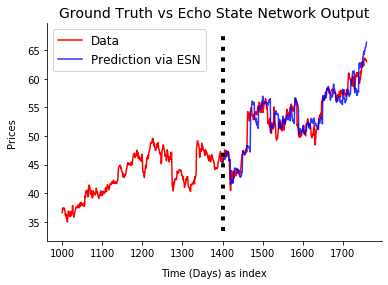

In [11]:
import seaborn as sns
plt.plot(range(1000,trainlen+futureTotal),data[1000:trainlen+futureTotal],'b',label="Data",color='red')
plt.plot(range(trainlen,trainlen+futureTotal),pred_tot,'k',  alpha=0.8, label='Prediction via ESN',color='blue')
lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:', linewidth=4)
plt.title(r'Ground Truth vs Echo State Network Output', fontsize=14)
plt.xlabel(r'Time (Days) as index', fontsize=10,labelpad=10)
plt.ylabel(r'Prices', fontsize=10,labelpad=10)
plt.legend(fontsize='large', loc='best')
sns.despine()

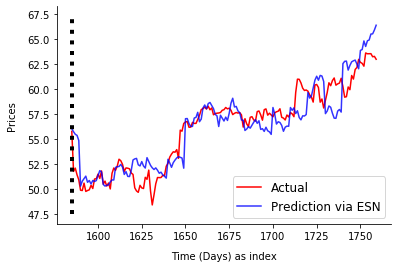

In [12]:
import seaborn as sns
plt.plot(range(1585,trainlen+futureTotal),data[1585:trainlen+futureTotal],'b',label="Actual",color='red')
plt.plot(range(1585,trainlen+futureTotal),pred_tot[185:],'k',  alpha=0.8, label='Prediction via ESN',color='blue')
lo,hi = plt.ylim()
plt.plot([1585,1585],[lo+np.spacing(1),hi-np.spacing(1)],'k:', linewidth=4)
plt.xlabel(r'Time (Days) as index', fontsize=10,labelpad=10)
plt.ylabel(r'Prices', fontsize=10,labelpad=10)
plt.legend(fontsize='large', loc='best')
sns.despine()

In [13]:
esn

In [14]:
def MSE(yhat, y):
    return np.sqrt(np.mean((yhat.flatten() - y)**2))

In [ ]:
n_reservoir= 500
sparsity   = 0.2
rand_seed  = 23
radius_set = [0.9,  1,  1.1]
noise_set = [ 0.001, 0.004, 0.006]
radius_set = [0.5, 0.7, 0.9,  1,  1.1,1.3,1.5]
noise_set = [ 0.0001, 0.0003,0.0007, 0.001, 0.003, 0.005, 0.007,0.01]
radius_set_size  = len(radius_set)
noise_set_size = len(noise_set)
trainlen = 1400
future = 2
futureTotal= 360
loss = np.zeros([radius_set_size, noise_set_size])
for l in range(radius_set_size):
    rho = radius_set[l]
    for j in range(noise_set_size):
        noise = noise_set[j]

        pred_tot=np.zeros(futureTotal)

        esn = ESN(n_inputs = 1,
          n_outputs = 1, 
          n_reservoir = n_reservoir,
          sparsity=sparsity,
          random_state=rand_seed,
          spectral_radius = rho,
          noise=noise)

        for i in range(0,futureTotal,future):
            pred_training = esn.fit(np.ones(trainlen),data[i:trainlen+i])
            prediction = esn.predict(np.ones(future))
            pred_tot[i:i+future] = prediction[:,0]
        
        loss[l, j] = MSE(pred_tot, data[trainlen:trainlen+futureTotal])        

In [121]:
minLoss = np.min(loss)
index_min = np.where(loss == minLoss)
index_min
rho_opt = radius_set[int(index_min[0])]
noise_opt = noise_set[int(index_min[1])]
print('The optimal set is:\nspectrum radius = ',
      rho_opt,'\nnoise = ',noise_opt,'\nMSE = ',minLoss)

The optimal set is:
spectrum radius =  1 
noise =  0.01 
MSE =  6.843724780698345


In [124]:
from sklearn.metrics import r2_score
print(r2_score(pred_tot[185:],data[1585:trainlen+futureTotal]))

0.9290683479823375
